In [7]:
import yfinance as yf
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.optimize import minimize
from statsmodels.tsa.stattools import coint
from statsmodels.tsa.api import VAR
from datetime import datetime, timedelta
import logging
import pickle
import databento as db
import os
from tqdm import tqdm

logging.basicConfig(level=logging.INFO)

In [8]:
from helpers import fetch_and_sort_filenames 

# Example usage
directory_path = './data/stock'
file_prefix = 'xnas-itch'
sorted_files = fetch_and_sort_filenames(directory_path, file_prefix)
sorted_files

['xnas-itch-20230501-20230531.ohlcv-1m.dbn.zst',
 'xnas-itch-20230601-20230630.ohlcv-1m.dbn.zst',
 'xnas-itch-20230701-20230731.ohlcv-1m.dbn.zst',
 'xnas-itch-20230801-20230831.ohlcv-1m.dbn.zst',
 'xnas-itch-20230901-20230930.ohlcv-1m.dbn.zst',
 'xnas-itch-20231001-20231031.ohlcv-1m.dbn.zst',
 'xnas-itch-20231101-20231130.ohlcv-1m.dbn.zst',
 'xnas-itch-20231201-20231231.ohlcv-1m.dbn.zst',
 'xnas-itch-20240101-20240131.ohlcv-1m.dbn.zst',
 'xnas-itch-20240201-20240229.ohlcv-1m.dbn.zst',
 'xnas-itch-20240301-20240331.ohlcv-1m.dbn.zst',
 'xnas-itch-20240401-20240430.ohlcv-1m.dbn.zst']

In [49]:
DATA_FOLDER = "./data/stock/"
# NOTE: Decrease num_months_traing low if running too slow
num_months_train = 11
train_files = sorted_files[:num_months_train]   # 11 months as training set
test_files = sorted_files[-1:]    # choose last month as the test set

df = pd.DataFrame()

for file_name in tqdm(train_files, desc="Loading Training files"):
    path = DATA_FOLDER + file_name
    stored_data = db.DBNStore.from_file(path)
    month_options = stored_data.to_df()
    df = pd.concat([df, month_options])

train_prices = df.pivot_table(index='ts_event', columns='symbol', values='close', aggfunc='first')
train_prices

Loading Training files: 100%|██████████| 11/11 [04:40<00:00, 25.50s/it]


symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
ts_event,,,,,,,,,,,,,,,,,,,,,
2023-05-01 08:00:00+00:00,NaN,NaN,169.57,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 08:01:00+00:00,NaN,NaN,169.36,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 08:02:00+00:00,NaN,NaN,169.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 08:03:00+00:00,NaN,NaN,169.50,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2023-05-01 08:04:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-28 23:55:00+00:00,NaN,NaN,171.14,NaN,NaN,NaN,NaN,NaN,504.25,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-28 23:56:00+00:00,NaN,NaN,171.18,NaN,164.36,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-03-28 23:57:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
df_test = pd.DataFrame()

for file_name in tqdm(test_files, desc="Loading Testing files"):
    path = DATA_FOLDER + file_name
    stored_data = db.DBNStore.from_file(path)
    month_options = stored_data.to_df()
    df_test = pd.concat([df_test, month_options])

test_prices = df_test.pivot_table(index='ts_event', columns='symbol', values='close', aggfunc='first')
test_prices

Loading Testing files: 100%|██████████| 1/1 [00:25<00:00, 25.25s/it]


symbol,A,AAL,AAPL,ABBV,ABNB,ABT,ACGL,ACN,ADBE,ADI,...,WTW,WY,WYNN,XEL,XOM,XYL,YUM,ZBH,ZBRA,ZTS
ts_event,,,,,,,,,,,,,,,,,,,,,
2024-04-01 08:00:00+00:00,NaN,15.4,171.52,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:01:00+00:00,NaN,NaN,171.75,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:02:00+00:00,NaN,NaN,171.79,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:03:00+00:00,NaN,NaN,171.83,NaN,NaN,NaN,NaN,NaN,507.99,NaN,...,NaN,NaN,NaN,NaN,116.52,NaN,NaN,NaN,NaN,NaN
2024-04-01 08:04:00+00:00,NaN,NaN,171.80,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30 23:55:00+00:00,NaN,NaN,170.10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30 23:56:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2024-04-30 23:57:00+00:00,NaN,NaN,170.06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
# "JKHY" in test_prices.columns

In [70]:
class StraddleSelector:
    def __init__(self, equities, lag_period, lookback_window = 10):
        self.equities = equities
        self.lag_period = lag_period
        self.lookback_window = lookback_window # 60
        self.var_models = {}
        self.results = []
        self.p_values_df = pd.DataFrame(columns=['Ticker1', 'Ticker2', 'P_Value', 'Correlation_Significant', 'Params', "Best_Lag"])
        self.initial_calculation_done = False

    def fetch_historical_data(self, ticker):
        """
        Fetch historical data for a given ticker
        """
        # display(yf.Ticker(ticker).history(period="1y"))
        # return yf.Ticker(ticker).history(period="1y")
        return df[df['symbol'] == ticker]

    def calculate_returns(self, historical_data):
        return np.log(historical_data / historical_data.shift(1)).dropna()

    def check_cointegration(self, merged_hist):
        _, p_value, _ = coint(merged_hist['close_1'], merged_hist['close_2'])
        return p_value < 0.05, p_value

    def calculate_rolling_correlation(self, returns1, returns2):
        return rolling_correlation(returns1, returns2, window=self.lookback_window)#lag_period)

    def fit_var_model(self, returns1, returns2, ticker1, ticker2):
        model_data = pd.concat([returns1, returns2], axis=1).dropna()
        model_data.columns = [ticker1, ticker2]
        var_model = VAR(model_data)
        return var_model.fit(maxlags=15, ic='aic')

    def store_p_values_and_models(self, ticker1, ticker2, p_value, correlation_significant, var_result):
        print("STORING")
        print(ticker1, ticker2)
        best_lag = var_result.k_ar

        coefficients_df = pd.DataFrame(var_result.params)

        params_dict = coefficients_df.to_dict(orient='index')

        new_row = pd.DataFrame({
            'Ticker1': [ticker1],
            'Ticker2': [ticker2],
            'P_Value': [p_value],
            'Correlation_Significant': [correlation_significant],
            # 'Var_Model': [var_result],
            'Best_Lag': [best_lag],
            'Params': [params_dict]
        })
        self.p_values_df = pd.concat([self.p_values_df, new_row], ignore_index=True)
        self.var_models[(ticker1, ticker2)] = var_result

        print("storing p values and models")

        # save to output/ticker_lags
        self.p_values_df.to_csv(f"output/ticker_lags.csv")

    def initial_calculations(self):
        for i, ticker1 in enumerate(tqdm(self.equities)):
            for ticker2 in self.equities[i+1:]:
                logging.info(f"Initial analysis for pair: {ticker1}, {ticker2}")

                hist1 = self.fetch_historical_data(ticker1)
                hist2 = self.fetch_historical_data(ticker2)

                merged_hist = hist1.join(hist2, how='inner', lsuffix='_1', rsuffix='_2').dropna()

                if merged_hist.empty:
                    logging.warning(f"No data for pair: {ticker1}, {ticker2}")
                    continue

                returns1 = self.calculate_returns(merged_hist["close_1"])
                returns2 = self.calculate_returns(merged_hist["close_2"])

                correlation_significant, p_value = self.check_cointegration(merged_hist)
                rolling_corr = self.calculate_rolling_correlation(returns1, returns2)
                significant = test_significance(rolling_corr.dropna())

                if not significant:
                    # continue
                    print("not significant")

                var_result = self.fit_var_model(returns1, returns2, ticker1, ticker2)
                # print(var_result.summary())
                self.store_p_values_and_models(ticker1, ticker2, p_value, correlation_significant, var_result)

        self.initial_calculation_done = True

    def fetch_latest_price(self, ticker):
        latest_price = yf.Ticker(ticker).history(period="1d")
        if latest_price.empty:
            logging.warning(f"No latest price data for {ticker}")
            return None
        return latest_price['Close'].iloc[-1]

    # Old function
    # def forecast_volatility_change(self, var_result):
    #     try:
    #         model_data = var_result.endog
    #         lag_order = var_result.k_ar

    #         if len(model_data) >= lag_order:
    #             forecast_input = model_data[-lag_order:]
    #             forecast = var_result.forecast(y=forecast_input, steps=1)
    #             vol_change = (forecast[0, 1] - forecast[0, 0]).item() # Difference in predicted returns
    #             std_change = float(np.std(forecast))
    #             return vol_change, std_change
    #         else:
    #             logging.warning(f"Not enough data points to perform forecasting")
    #             return 0.0, 0.0
    #     except Exception as e:
    #         logging.error(f"Error forecasting volatility change: {e}")
    #         return 0.0, 0.0

    def forecast_volatility_change(self, var_model, test_data, ticker1, ticker2):
        lag_order = var_model.k_ar

        if len(test_data) >= lag_order:
            # Initialize an empty DataFrame to store the predicted values
            predicted_data = pd.DataFrame(columns=[ticker1, ticker2], index = test_data.index[lag_order:])

            print("lag order", lag_order)

            returns1 = self.calculate_returns(test_data[ticker1])
            returns2 = self.calculate_returns(test_data[ticker2])

            returns_concat = pd.concat([returns1, returns2], axis=1).dropna()

            # Loop through each row in test_data
            for i in range(0, len(returns_concat)-lag_order):
                # Extract the current row from test_data
                window = returns_concat.iloc[i:i+lag_order]
                forecast_results = var_model.forecast(y=window[[ticker1, ticker2]].values, steps=1)
                
                # add to predicted data
                predicted_data.loc[test_data.index[i+lag_order], ticker1] = forecast_results[0][0]
                predicted_data.loc[test_data.index[i+lag_order], ticker2] = forecast_results[0][1]


            # TODO: Kavita -> Not sure what variables what
            display(predicted_data)

            # Concatenate test_data with predicted_data for comparison or further analysis
            # final_predicted_data = pd.concat([test_data, predicted_data], axis=1)
            # merge test_data and predicted_data for comparison
            final_predicted_data = pd.merge(returns_concat, predicted_data, left_index=True, right_index=True, suffixes=('_actual', '_predicted'))

            # Calculate rolling volatility (standard deviation of returns)
            # window_size = 20  # You can adjust this window size

            # ticker 2 is the lagged equity

            # for ticker in [ticker1, ticker2]:
            #     # Calculate rolling volatility (standard deviation of returns)
            #     final_predicted_data[f'vol_{ticker}'] = final_predicted_data[f'{ticker}_predicted'].rolling(window=window_size).std()
                
            #     # Shift the volatility to compute volatility change
            #     final_predicted_data[f'shifted_vol_{ticker}'] = final_predicted_data[f'vol_{ticker}'].shift(1)
                
            #     # Calculate volatility change
            #     final_predicted_data[f'vol_change_{ticker}'] = final_predicted_data[f'vol_{ticker}'] - final_predicted_data[f'shifted_vol_{ticker}']
                
            #     # Calculate the rolling standard deviation of the volatility (volatility_std)
            #     final_predicted_data[f'vol_std_{ticker}'] = final_predicted_data[f'vol_{ticker}'].rolling(window=window_size).std()
                
            #     # Drop the intermediate shifted_volatility column
            #     final_predicted_data.drop(columns=[f'shifted_vol_{ticker}'], inplace=True)

            final_predicted_data[f"{ticker2}_delta"] = final_predicted_data[f"{ticker2}_predicted"] - final_predicted_data[f"{ticker2}_actual"]
            display(final_predicted_data)

            return final_predicted_data
        else:
            logging.warning(f"Not enough data points to perform forecasting")
            return 0.0, 0.0

    def output_trades(self, final_predicted_data, ticker1, ticker2):
        """
        Generates trade signals based on the predicted data for two tickers.

        This function determines buy ('C' for call) and sell ('P' for put) signals for the given tickers
        based on their predicted values. The signals are generated based on the 5th and 95th percentiles of the
        predicted data.

        Parameters:
        final_predicted_data (pd.DataFrame): A DataFrame containing the predicted data for the tickers.
                                            It should have columns named '{ticker}_predicted' for each ticker.
        ticker1 (str): The first ticker symbol.
        ticker2 (str): The second ticker symbol.

        Returns:
        pd.DataFrame: The input DataFrame with additional columns '{ticker1}_trade' and '{ticker2}_trade'
                    containing the generated trade signals.

        Notes:
        - The trade signal is 'C' if the predicted value is above the 95th percentile.
        - The trade signal is 'P' if the predicted value is below the 5th percentile.
        - No trade signal (NaN) is assigned if the predicted value is between the 5th and 95th percentiles.

        Example:
        final_predicted_data = output_trades(final_predicted_data, 'AAPL', 'GOOGL')
        """
        # TODO: Kavita change this to stratefy
        # for ticker in (ticker1, ticker2):
            # # Calculate the 5th and 95th percentiles for the predicted data
            # percentile_5  = final_predicted_data[f'{ticker}_predicted'].quantile(0.05)
            # percentile_95 = final_predicted_data[f'{ticker}_predicted'].quantile(0.95)

            # # Create the trade column based on the conditions
            # final_predicted_data[f'{ticker}_trade'] = np.where(
            #     final_predicted_data[f'{ticker}_predicted'] > percentile_95, 'C', 
            #     np.where(final_predicted_data[f'{ticker}_predicted'] < percentile_5, 'P', np.nan)
            # )

        percentile_5  = final_predicted_data[f'{ticker2}_delta'].quantile(0.05)
        percentile_95 = final_predicted_data[f'{ticker2}_delta'].quantile(0.95)

        # Create the trade column based on the conditions
        final_predicted_data[f'{ticker2}_trade'] = np.where(
            final_predicted_data[f'{ticker2}_delta'] > percentile_95, 'P', 
            np.where(final_predicted_data[f'{ticker2}_delta'] < percentile_5, 'C', np.nan)
        )

        return final_predicted_data

    def update_decisions(self):
        print("update decisions")
        print(self.var_models.items())
    
        if not self.initial_calculation_done:
            logging.info("Initial calculations not done yet.")
            return

        for (ticker1, ticker2), var_result in self.var_models.items():
            logging.info(f"Updating decisions for pair: {ticker1}, {ticker2}")
            print(f"Updating decisions for pair: {ticker1}, {ticker2}")

            test_data = test_prices[[ticker1, ticker2]].dropna()
            display(test_data)

            # vol_change, std_change = self.forecast_volatility_change(var_result, test_data, ticker1, ticker2)
            final_predicted_data = self.forecast_volatility_change(var_result, test_data, ticker1, ticker2)

            # save to csv
            final_predicted_data.to_csv(f"output/{ticker1}_{ticker2}_final_pred.csv")

            # final_predicted_data[f"{ticker2}_predicted"].plot()

            trades_df = self.output_trades(final_predicted_data, ticker1, ticker2)

            # save to csv 
            print(f"saving trades to csv ({ticker1}_{ticker2}_trades)")
            trades_df.to_csv(f"output/{ticker1}_{ticker2}_trades.csv")

            display(trades_df)

    def evaluate_straddle_options(self, ticker1, ticker2, S, expirations, predicted_mean_change):
        pair_results = []

        for expiration in expirations:
            T = (pd.to_datetime(expiration) - pd.Timestamp.today()).days / 365.0

            hist1 = self.fetch_historical_data(ticker1)
            returns1 = self.calculate_returns(hist1)
            sigma = returns1.std() * np.sqrt(252)

            strike_min = S * 0.8
            strike_max = S * 1.2
            initial_guess = S

            result = minimize(objective, initial_guess, args=(S, T, 0.05, sigma), bounds=[(strike_min, strike_max)], method='L-BFGS-B')
            K_opt = result.x[0]

            profit_up, profit_down, profit_no_move, total_cost = straddle_profit(S, K_opt, T, 0.05, sigma)
            profits = [profit_up, profit_down, profit_no_move]

            pair_results.append({
                'Expiration': expiration,
                'Strike': K_opt,
                'Total_Cost': total_cost,
                'Profit_Up': profit_up,
                'Profit_Down': profit_down,
                'Profit_No_Move': profit_no_move,
                # 'Profits': profits,
                'Sharpe_Ratio': sharpe_ratio(profits, 0.05),
                'Ticker1': ticker1,
                'Ticker2': ticker2
            })

        self.results.extend(pair_results)
        self.select_best_straddle(pair_results, predicted_mean_change)

    def select_best_straddle(self, pair_results, predicted_mean_change):
        best_result = max(pair_results, key=lambda x: x['Sharpe_Ratio'])

        threshold = 0.05
        if predicted_mean_change > threshold:
            logging.info(f"Best Straddle - Expiration: {best_result['Expiration']}, Strike: {best_result['Strike']}, Total Cost: {best_result['Total_Cost']}")
            logging.info(f"Profit if price moves up: {best_result['Profit_Up']}, Profit if price moves down: {best_result['Profit_Down']}, Profit if no movement: {best_result['Profit_No_Move']}")
            logging.info(f"Sharpe Ratio: {best_result['Sharpe_Ratio']}")
        else:
            logging.info("Predicted price change does not meet the threshold for making a purchase.")

    def run_iterations(self, num_iterations):
        print("Running iterations")
        for i in range(num_iterations):
            logging.info(f"Running iteration {i + 1}/{num_iterations}")
            self.update_decisions()
            logging.info(f"Iteration {i + 1} completed")
            # Print the results for the current iteration
            for result in self.results:
                logging.info(result)

def rolling_correlation(data1, data2, window=30):
    return data1.rolling(window).corr(data2)

def test_significance(correlation_series, alpha=0.05):
    mean_corr = correlation_series.mean()
    std_corr = correlation_series.std()
    t_stat = mean_corr / (std_corr / np.sqrt(len(correlation_series)))
    p_value = 2 * (1 - norm.cdf(np.abs(t_stat)))  # two-tailed test
    return p_value < alpha

def bayesian_inference(S, vol_change, std_change, n=10000):
    predicted_changes = np.random.normal(loc=vol_change, scale=std_change, size=n)
    future_prices = S * (1 + predicted_changes)
    return future_prices.mean(), future_prices.std()

def binomial_tree_american(S, K, T, r, sigma, option_type='call', steps=100):
    dt = T / steps
    u = np.exp(sigma * np.sqrt(dt))
    d = 1 / u
    p = (np.exp(r * dt) - d) / (u - d)
    
    option_values = np.zeros((steps + 1, steps + 1))
    
    # Initialize the option values at maturity
    for i in range(steps + 1):
        if option_type == 'call':
            option_values[i, steps] = max(0, S * (u ** (steps - i)) * (d ** i) - K)
        elif option_type == 'put':
            option_values[i, steps] = max(0, K - S * (u ** (steps - i)) * (d ** i))
    
    # Step back through the tree
    for j in range(steps - 1, -1, -1):
        for i in range(j + 1):
            option_value_if_held = np.exp(-r * dt) * (p * option_values[i, j + 1] + (1 - p) * option_values[i + 1, j + 1])
            if option_type == 'call':
                option_value_if_exercised = S * (u ** i) * (d ** (j - i)) - K
            elif option_type == 'put':
                option_value_if_exercised = K - S * (u ** i) * (d ** (j - i))
            
            # Ensure we use scalar values in maximum comparison
            option_values[i, j] = max(option_value_if_held.item(), option_value_if_exercised.item())

    
    return option_values[0, 0]

def straddle_profit(S, K, T, r, sigma, steps=100):
    call_price = binomial_tree_american(S, K, T, r, sigma, 'call', steps)
    put_price = binomial_tree_american(S, K, T, r, sigma, 'put', steps)
    total_cost = call_price + put_price
    
    profit_up = max(S + (S * 0.2) - K, 0) + max(K - (S + (S * 0.2)), 0) - total_cost
    profit_down = max(K - (S - (S * 0.2)), 0) + max((S - (S * 0.2)) - K, 0) - total_cost
    profit_no_move = -total_cost
    
    return profit_up, profit_down, profit_no_move, total_cost

def objective(K, S, T, r, sigma, steps=100):
    profit_up, profit_down, profit_no_move, _ = straddle_profit(S, K, T, r, sigma, steps)
    return - (profit_up + profit_down + profit_no_move)  # Minimize negative profit (maximize profit)

def sharpe_ratio(profits, risk_free_rate):
    expected_return = np.mean(profits)
    std_dev = np.std(profits)
    return (expected_return - risk_free_rate) / std_dev

# Define list of 50 equities
equities = [
    'AAPL', 'MSFT', 'GOOGL', 'AMZN', 'META', 'TSLA', 'BRK-B', 'V', 'JNJ', 'WMT', 
    'JPM', 'PG', 'UNH', 'DIS', 'NVDA', 'HD', 'MA', 'VZ', 'PYPL', 'ADBE', 
    'NFLX', 'INTC', 'KO', 'PFE', 'CSCO', 'PEP', 'T', 'MRK', 'ABT', 'XOM', 
    'NKE', 'MCD', 'CRM', 'LLY', 'MDT', 'AMGN', 'NEE', 'BA', 'COST', 'AVGO', 
    'IBM', 'HON', 'ACN', 'TMO', 'MMM', 'TXN', 'UNP', 'QCOM', 'LOW'
]
# equities = ['AAPL', 'MSFT', 'GOOGL']
equities = ['AAPL', 'MSFT']
# equities = ["JKHY", "PCG"]
lag_period = 1

# Initialize StraddleSelector and perform initial calculations
straddle_selector = StraddleSelector(equities, lag_period)
straddle_selector.initial_calculations()

# Run for a fixed number of iterations
straddle_selector.run_iterations(num_iterations=1)


  0%|          | 0/2 [00:00<?, ?it/s]

INFO:root:Initial analysis for pair: AAPL, MSFT
/usr/local/Caskroom/miniconda/base/envs/MSE244/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/var/folders/h6/sy6yc4qn7vg_qrvftw3gqnl00000gn/T/ipykernel_30366/666052449.py:53: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  self.p_values_df = pd.concat([self.p_values_df, new_row], ignore_index=True)
100%|██████████| 2/2 [02:24<00:00, 72.19s/it] 
INFO:root:Running iteration 1/1
INFO:root:Updating decisions for pair: AAPL, MSFT


STORING
AAPL MSFT
storing p values and models
Running iterations
update decisions
dict_items([(('AAPL', 'MSFT'), <statsmodels.tsa.vector_ar.var_model.VARResultsWrapper object at 0x1ae10add0>)])
Updating decisions for pair: AAPL, MSFT


symbol,AAPL,MSFT
ts_event,,
2024-04-01 08:00:00+00:00,171.52,424.89
2024-04-01 08:01:00+00:00,171.75,424.03
2024-04-01 08:02:00+00:00,171.79,423.32
2024-04-01 08:03:00+00:00,171.83,423.41
2024-04-01 08:05:00+00:00,171.79,423.46
...,...,...
2024-04-30 23:52:00+00:00,170.14,390.43
2024-04-30 23:55:00+00:00,170.10,390.40
2024-04-30 23:57:00+00:00,170.06,390.50


lag order 15


,AAPL,MSFT
ts_event,,
2024-04-01 08:21:00+00:00,0.000009,0.000002
2024-04-01 08:22:00+00:00,0.000017,-0.000032
2024-04-01 08:23:00+00:00,-0.000003,0.0
2024-04-01 08:24:00+00:00,-0.0,0.000004
2024-04-01 08:25:00+00:00,-0.000008,0.000001
...,...,...
2024-04-30 23:52:00+00:00,0.000002,0.000008
2024-04-30 23:55:00+00:00,0.00001,-0.000016
2024-04-30 23:57:00+00:00,0.000001,-0.000017


,AAPL_actual,MSFT_actual,AAPL_predicted,MSFT_predicted,MSFT_delta
ts_event,,,,,
2024-04-01 08:21:00+00:00,0.000000,-0.000071,0.000009,0.000002,0.000073
2024-04-01 08:22:00+00:00,-0.000058,0.000024,0.000017,-0.000032,-0.000055
2024-04-01 08:23:00+00:00,0.000000,0.000000,-0.000003,0.0,0.0
2024-04-01 08:24:00+00:00,0.000000,-0.000047,-0.0,0.000004,0.000052
2024-04-01 08:25:00+00:00,-0.000058,0.000047,-0.000008,0.000001,-0.000046
...,...,...,...,...,...
2024-04-30 23:52:00+00:00,-0.000176,-0.000051,0.000002,0.000008,0.00006
2024-04-30 23:55:00+00:00,-0.000235,-0.000077,0.00001,-0.000016,0.000061
2024-04-30 23:57:00+00:00,-0.000235,0.000256,0.000001,-0.000017,-0.000273


saving trades to csv (AAPL_MSFT_trades)


,AAPL_actual,MSFT_actual,AAPL_predicted,MSFT_predicted,MSFT_delta,MSFT_trade
ts_event,,,,,,
2024-04-01 08:21:00+00:00,0.000000,-0.000071,0.000009,0.000002,0.000073,nan
2024-04-01 08:22:00+00:00,-0.000058,0.000024,0.000017,-0.000032,-0.000055,nan
2024-04-01 08:23:00+00:00,0.000000,0.000000,-0.000003,0.0,0.0,nan
2024-04-01 08:24:00+00:00,0.000000,-0.000047,-0.0,0.000004,0.000052,nan
2024-04-01 08:25:00+00:00,-0.000058,0.000047,-0.000008,0.000001,-0.000046,nan
...,...,...,...,...,...,...
2024-04-30 23:52:00+00:00,-0.000176,-0.000051,0.000002,0.000008,0.00006,nan
2024-04-30 23:55:00+00:00,-0.000235,-0.000077,0.00001,-0.000016,0.000061,nan
2024-04-30 23:57:00+00:00,-0.000235,0.000256,0.000001,-0.000017,-0.000273,nan


INFO:root:Iteration 1 completed


# Analysis

In [65]:
# read in output/{ticker1}_ticker2_final_pred.csv
ticker1, ticker2 = equities[0], equities[1]
final_pred = pd.read_csv(f"output/{ticker1}_{ticker2}_final_pred.csv")
final_pred

,ts_event,JKHY_actual,PCG_actual,JKHY_predicted,PCG_predicted,PCG_delta
0,2024-04-01 13:52:00+00:00,-0.001304,0.000301,0.000247,-0.000023,-0.000324
1,2024-04-01 13:53:00+00:00,-0.001742,-0.000301,0.000373,-0.000049,0.000252
2,2024-04-01 13:54:00+00:00,0.001945,-0.000301,-0.000292,0.000032,0.000333
3,2024-04-01 13:55:00+00:00,-0.000870,0.000301,0.000134,0.000012,-0.000289
4,2024-04-01 13:59:00+00:00,0.000754,-0.000602,-0.000179,0.000083,0.000686
...,...,...,...,...,...,...
6299,2024-04-30 19:55:00+00:00,0.000338,0.000000,-0.000020,0.000026,0.000026
6300,2024-04-30 19:56:00+00:00,-0.000676,-0.000584,0.000053,0.000052,0.000636
6301,2024-04-30 19:57:00+00:00,0.000061,0.000000,-0.000021,-0.000011,-0.000011
6302,2024-04-30 19:58:00+00:00,-0.000553,0.000000,0.000112,0.000015,0.000015


<Axes: >

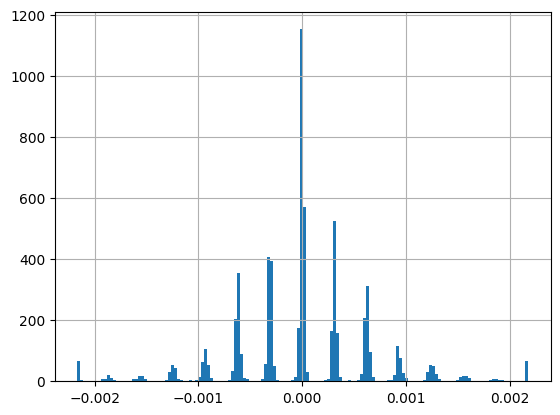

In [66]:
from scipy.stats.mstats import winsorize

col_name = f"{ticker2}_delta"
final_pred[col_name+"_winsorized"] = winsorize(final_pred[col_name], limits=[0.01, 0.01])
final_pred[col_name+"_winsorized"].hist(bins=150)
# 

## Fit different distributions

In [67]:
from scipy.stats import beta, norm, gamma, uniform, expon, weibull_min, lognorm, triang, logistic, cauchy, pareto, chi2, betaprime, gumbel_r, laplace, foldnorm
from scipy import stats
import matplotlib.pyplot as plt

# Generate or load your data
data = final_pred[col_name+"_winsorized"].to_numpy()

distributions = [beta, norm, gamma, uniform, expon, weibull_min, lognorm, triang, logistic, cauchy, pareto, chi2, betaprime, gumbel_r, laplace, foldnorm]
dist_to_ks = {}

for distribution in distributions:
    params = distribution.fit(data)
    ks_statistic = stats.kstest(data, distribution.cdf, args=params)[0]

    dist_to_ks[distribution.name] = ks_statistic

# sort the dictionary by value
dist_to_ks = dict(sorted(dist_to_ks.items(), key=lambda item: item[1]))
dist_to_ks

/usr/local/Caskroom/miniconda/base/envs/MSE244/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:723: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  a, b = optimize.fsolve(func, (1.0, 1.0))
/usr/local/Caskroom/miniconda/base/envs/MSE244/lib/python3.11/site-packages/scipy/stats/_continuous_distns.py:6547: RuntimeWarning: invalid value encountered in log
  lndata = np.log(data - loc)


{'cauchy': 0.11293044055386081,
 'laplace': 0.11929346648714734,
 'logistic': 0.12681624118229606,
 'gamma': 0.13122024657113895,
 'lognorm': 0.13123074101790022,
 'beta': 0.13218508587739763,
 'norm': 0.1322722363763058,
 'weibull_min': 0.13870021205509175,
 'triang': 0.15358251951375856,
 'gumbel_r': 0.1604127947603382,
 'uniform': 0.24889716354849833,
 'expon': 0.4033584221257206,
 'pareto': 0.40335842393475974,
 'foldnorm': 0.5358729844796118,
 'betaprime': 0.5461138441035254,
 'chi2': 0.5479427205576506}

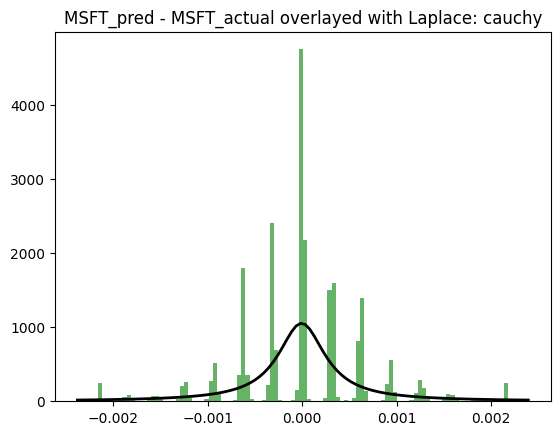

In [68]:
# Plot the best fitting distributions
best_distribution = cauchy  

plt.hist(data, bins=100, density=True, alpha=0.6, color='g')
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
pdf = best_distribution.pdf(x, *best_distribution.fit(data))
plt.plot(x, pdf, 'k-', linewidth=2)
plt.title(f'MSFT_pred - MSFT_actual overlayed with Laplace: {best_distribution.name}')
plt.show()